In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys
from torch.utils.data import Subset, DataLoader
from sklearn.decomposition import PCA
sys.path.append("../hyperLAI")
sys.path.append("../../")
from utils.model_utils import *
from features.hyperLAIdataset import HyperLoader
from models.fc_model import fc_model
from HypHC.utils.visualization import plot_tree_from_leaves
from tqdm import tqdm_notebook

In [2]:
def plot_weights_pca(embeddings, labels, annotations=None):
    '''
    Plot PCA of embedding
    '''
    weights_pca = PCA().fit_transform(embeddings)
    scplot = sns.scatterplot(x=weights_pca[:,0], y=weights_pca[:,1], hue=labels)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA of Embedding Weights")
    if annotations is not None:
        for line in range(len(labels)):
#             if labels[line] != "SAS" or weights_pca[line,0] > 0.5 or weights_pca[line,1] > 0.1:
#                 continue
            scplot.text(weights_pca[line,0]+0.005, weights_pca[line,1], 
                         annotations[line], horizontalalignment='left', color='black', size=8)


In [3]:
model_dir = "/home/users/patelas/hyperLAI/models/scratch/second_test_fc/"
config = read_config(model_dir + "fc_config.json")

In [4]:
dataset = HyperLoader(config["data_dir"], config["restrict_labels"], config["chromosome"])
train_indices, valid_indices, test_indices = train_valid_test(len(dataset), config["train_perc"], config["valid_perc"])
valid_data = Subset(dataset, valid_indices)
valid_loader = DataLoader(valid_data, batch_size=64)

start reading ...
File read: 317408 SNPs for 3558 individuals
done loading vcf... Shape of vcf file is :  (317408, 3558, 2) Shape of vcf names file is (3558,)
TSV loaded Index(['Sample', 'Population code', 'Population', 'Superpopulation code',
       'Superpopulation', 'Source', 'Latitude', 'Longitude', 'Region',
       'Sample Alias', 'Country', 'Town', 'Single_Ancestry'],
      dtype='object') DF shape is  (3558, 13)
Super population code are ,  ['EUR', 'EAS', 'AMR', 'SAS', 'AFR', 'OCE', 'WAS'] 7
Population code are ,  ['GBR', 'FIN', 'CHS', 'PUR', 'CDX', 'CLM', 'IBS', 'PEL', 'PJL', 'KHV', 'ACB', 'GWD', 'ESN', 'BEB', 'MSL', 'STU', 'ITU', 'CEU', 'YRI', 'CHB', 'JPT', 'LWK', 'ASW', 'MXL', 'TSI', 'GIH', nan] 27
Population names are ,  ['British', 'Finnish', 'Southern Han Chinese', 'Puerto Rican', 'Dai Chinese', 'Colombian', 'Spanish', 'Peruvian', 'Punjabi', 'Kinh Vietnamese', 'African-Caribbean', 'Gambian Mandinka', 'Esan', 'Bengali', 'Mende', 'Sri Lankan', 'Indian Telugu', 'CEPH', 'Yorub

In [5]:
model = fc_model(dataset.snps.shape[1], config["num_int_layers"], config["int_layer_sizes"], config["embedding_size"], 
                 config["dropout_vals"], config["temperature"], config["init_size"], config["min_scale"], config["max_scale"])
model_info = torch.load("%smodel.pt"%(model_dir))
model.load_state_dict(model_info["model_state"])


<All keys matched successfully>

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
model.eval()
embeddings, suppop_labels, pop_labels = [], [], []
with torch.no_grad():
    for i, (snp_data, suppop, pop) in enumerate(valid_loader):
        embs = model(snp_data.float().to(device))
        embeddings.append(embs.cpu())
        suppop_labels.append(suppop)
        pop_labels.append(pop)

In [7]:
embeddings = torch.cat(embeddings).numpy()
suppop_labels = torch.cat(suppop_labels).numpy()
pop_labels = torch.cat(pop_labels).numpy()

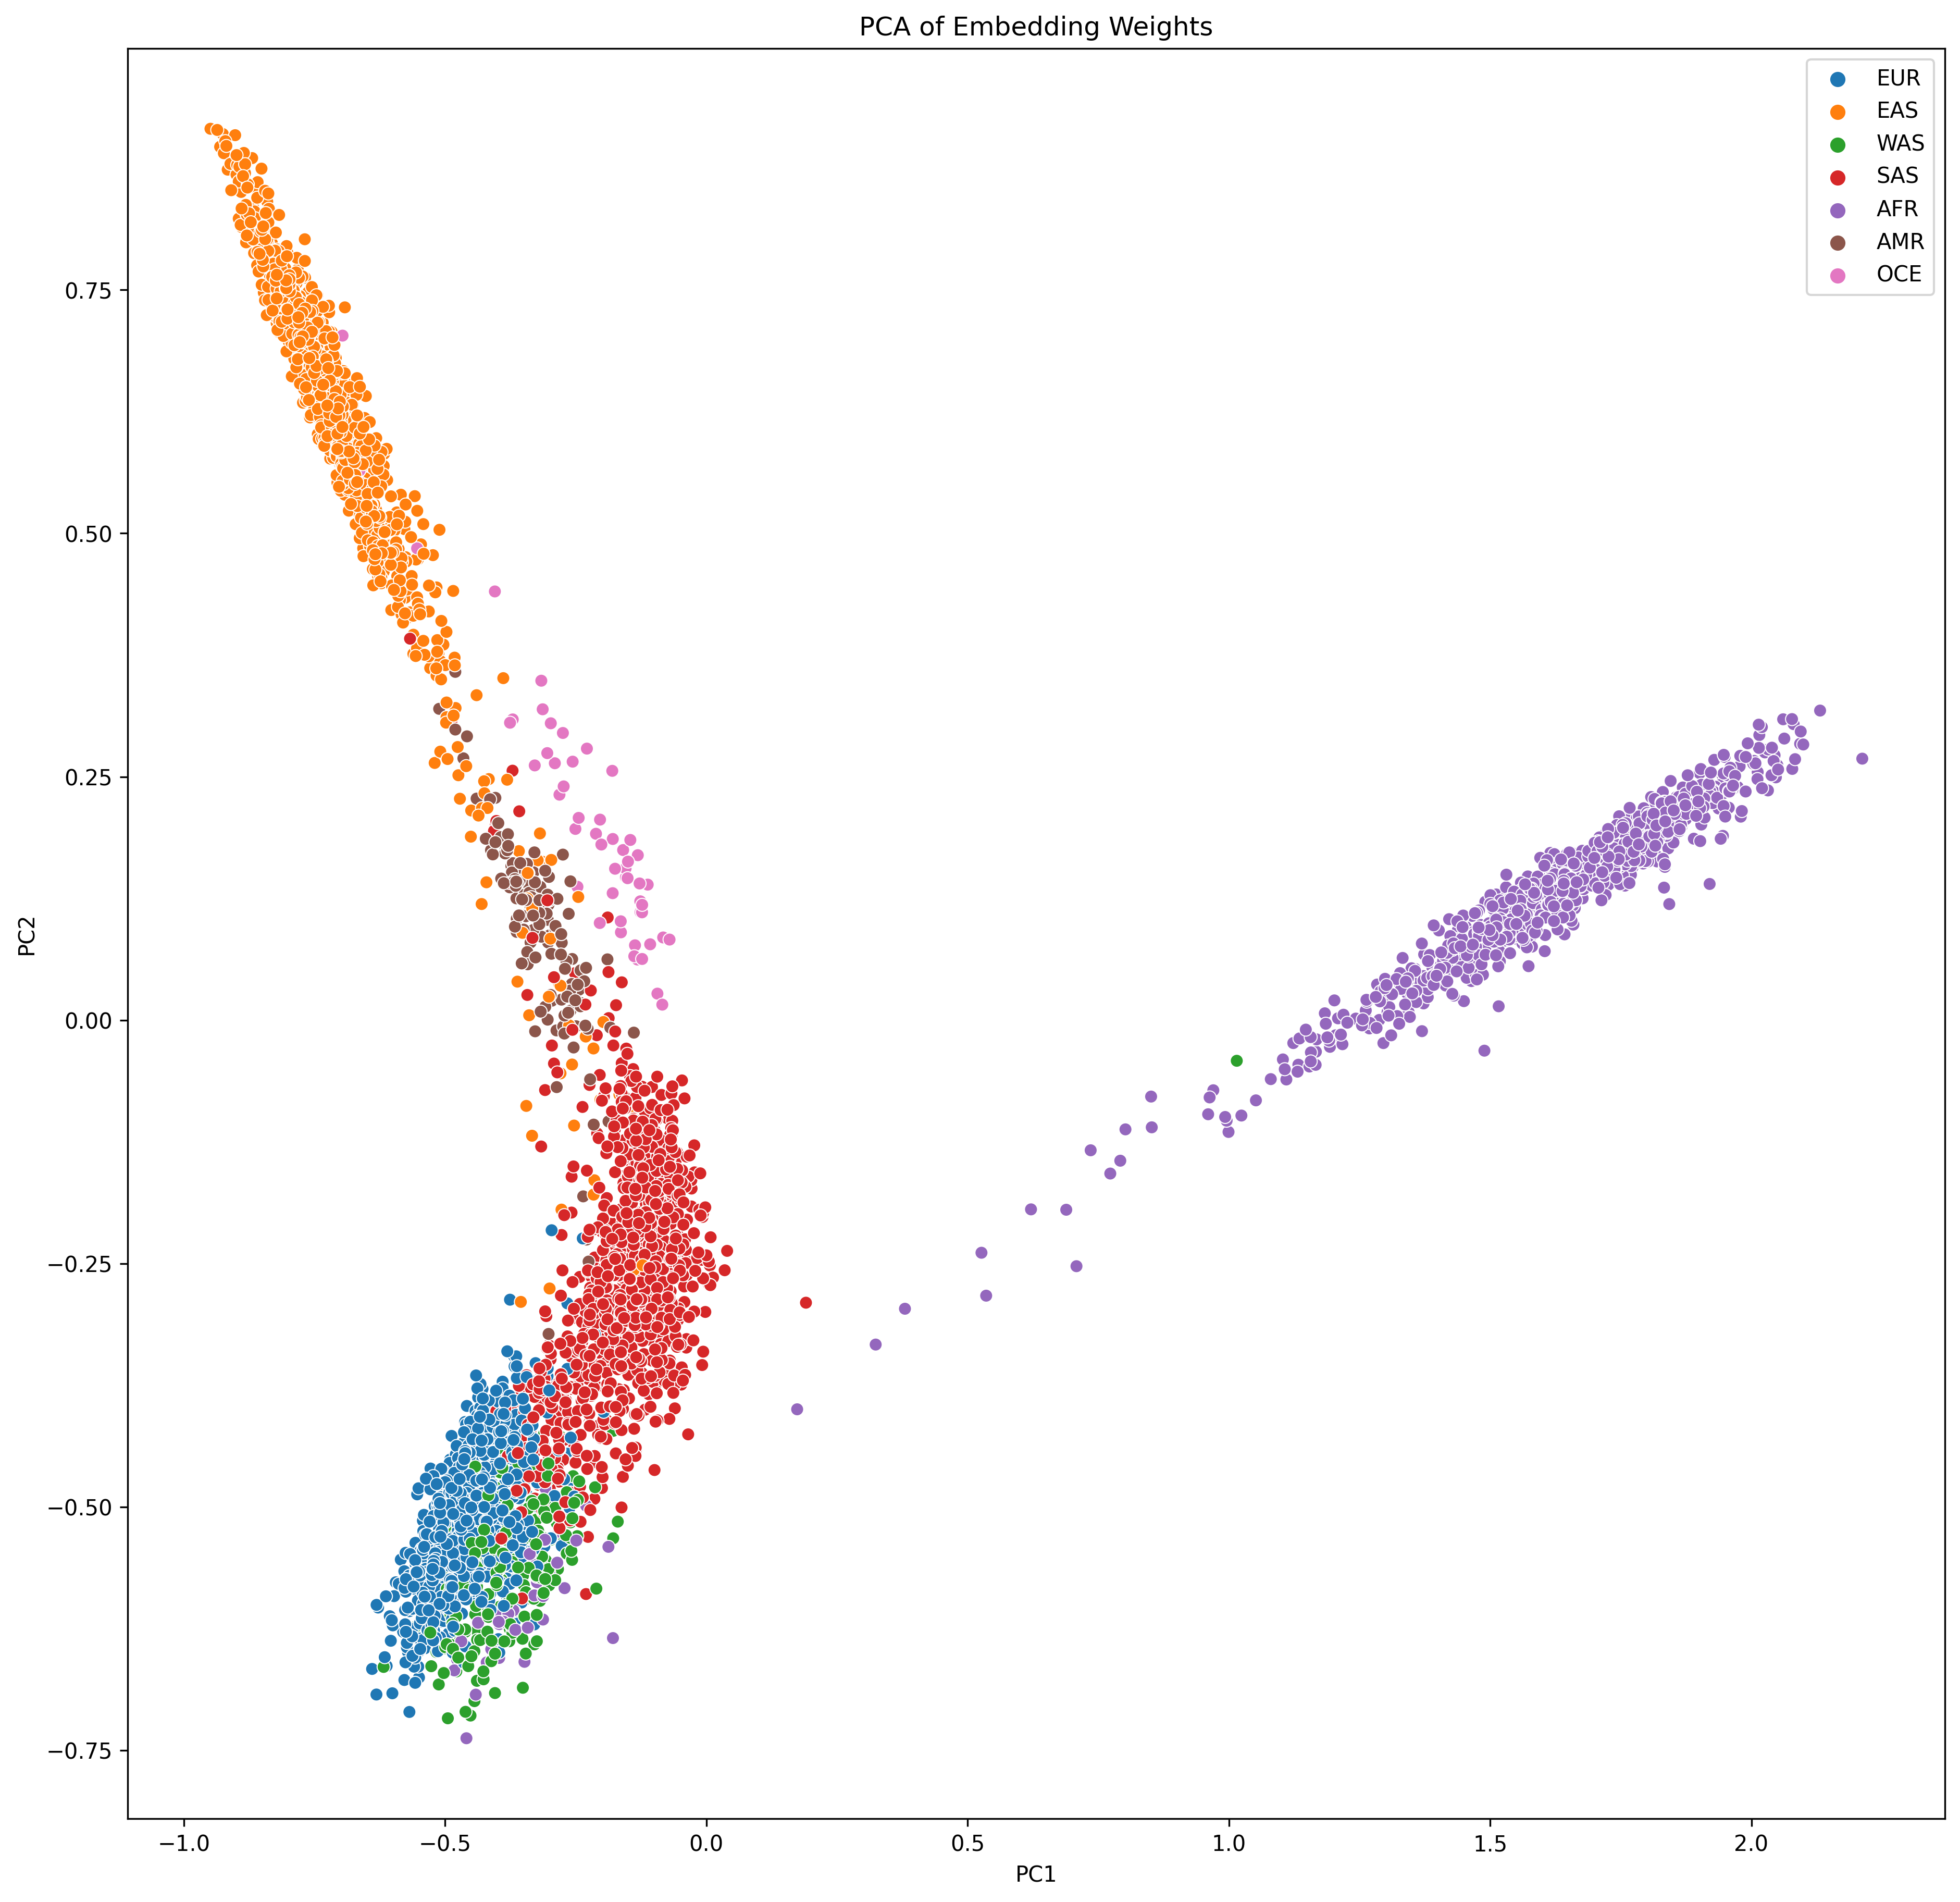

In [8]:
plt.figure(figsize=[15, 15], dpi=300)
sp_full = [dataset.suppop_label_index[x] for x in suppop_labels]
p_full = [dataset.pop_label_index[x] for x in pop_labels]
plot_weights_pca(embeddings, sp_full)
plt.show()

In [24]:
len(dataset)

5930